In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!pip install -q kaggle


In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!ls

kaggle.json  sample_data


In [6]:
!kaggle datasets download -d qwertyaditya/elo-test-train-cleaned-1

 35% 5.00M/14.4M [00:00<00:00, 46.7MB/s]
100% 14.4M/14.4M [00:00<00:00, 102MB/s] 


In [7]:
%mkdir -p dataset/


In [8]:
!ls

dataset  elo-test-train-cleaned-1.zip  kaggle.json  sample_data


In [9]:
!unzip -q elo-test-train-cleaned-1.zip -d dataset/

In [10]:
!pwd


/content


In [11]:
!ls ../content/dataset/


test_dataset.csv  train_dataset.csv


In [12]:
train_df = pd.read_csv("../content/dataset/train_dataset.csv")
test_df = pd.read_csv("../content/dataset/test_dataset.csv")

In [13]:
train_df.head()


,Unnamed: 0,card_id,feature_1,feature_2,feature_3,target,year,month,city_id,category_1,installments,category_3,month_lag,purchase_date_year,purchase_date_month,purchase_date_week,purchase_date_day,purchase_date_hour
0,0,C_ID_92a2005557,5,2,1,-0.820283,2017,6,19.0,0,0.0,1,1.0,2018,3,2.0,2.0,0.0
1,1,C_ID_92a2005557,5,2,1,-0.820283,2017,6,69.0,0,0.0,1,2.0,2018,4,2.0,0.0,0.0
2,2,C_ID_92a2005557,5,2,1,-0.820283,2017,6,19.0,0,0.0,1,1.0,2018,3,2.0,2.0,1.0
3,3,C_ID_92a2005557,5,2,1,-0.820283,2017,6,69.0,0,0.0,1,2.0,2018,4,3.0,0.0,1.0
4,4,C_ID_92a2005557,5,2,1,-0.820283,2017,6,276.0,0,0.0,1,1.0,2018,3,1.0,1.0,2.0


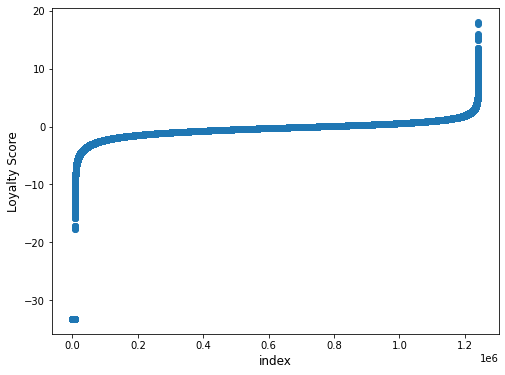

In [14]:
target_col = "target"

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

In [15]:
(train_df[target_col]<-30).sum()

8035

In [21]:
# train_df["year"] = train_df["purchase_date_month"]
# test_df["year"] = test_df["purchase_date_month"]
# train_df["month"] = train_df["purchase_date_month"]
# test_df["month"] = test_df["purchase_date_month"]

# cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month"]

# def run_lgb(train_X, train_y, val_X, val_y, test_X):
#     params = {
#         "objective" : "regression",
#         "metric" : "rmse",
#         "num_leaves" : 30,
#         "min_child_weight" : 50,
#         "learning_rate" : 0.05,
#         "bagging_fraction" : 0.7,
#         "feature_fraction" : 0.7,
#         "bagging_frequency" : 5,
#         "bagging_seed" : 2018,
#         "verbosity" : -1
#     }
    
  

In [60]:
train_df["year"] = train_df["purchase_date_month"]
test_df["year"] = test_df["purchase_date_month"]
train_df["month"] = train_df["purchase_date_month"]
test_df["month"] = test_df["purchase_date_month"]

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month",]

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    # model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

# pred_test = 0
# kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
# for dev_index, val_index in kf.split(train_df):
#     dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
#     dev_y, val_y = train_y[dev_index], train_y[val_index]
    
#     pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
#     pred_test += pred_test_tmp
# pred_test /= 5.
    

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:

from sklearn.metrics import mean_absolute_error

In [63]:
# forest_model = RandomForestRegressor(random_state=1)
# forest_model.fit(train_X, train_y)
# melb_preds = forest_model.predict(val_X)
# print(mean_absolute_error(val_y, melb_preds))

In [64]:
import pandas as pd
dataset=pd.read_csv("../content/dataset/train_dataset.csv")

In [65]:
# #split x and y
# x = dataset.drop('year', axis = 1)
# y = dataset['purchase_date_month']

In [66]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size = 0.25, random_state = 0)

In [101]:
# Fitting Random Forest Regression to the Training set
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 25, random_state = 0)


In [102]:
regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=25, random_state=0)

In [103]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [104]:
# Evaluating the Algorithm
from sklearn import metrics
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Root Mean Squared Error: 2.9265994349561875


In [105]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv("elo_random_forest_25.csv", index=False)